# Kaggle House Prices

This competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/

It is old, and the leaderboard is saturated with perfect submissions. But it looks like great classic ML practice, and I can take inspiration from another submission: https://github.com/sushant2811/KaggleHousingPrices

## Pipeline

1. Clean variables (without fitting to any data)
    - Convert obvious candidates for ordinals into ordinals
    - Process: combine/remove variables as is reasonable, and log1p transform any variables for cost or area
    - Impute GarageYrBlt which has a natural imputation
2. Use the training data to impute and encode
    - Fit imputers using the training data (median for numeric, mode for ordinal and categorical)
    - Custom imputer for LotFrontage, which will be a linear function of LotArea
    - Manual imputer for categoricals, since the SimpleImputer doesn't work on strings
    - One-hot categoricals (making sure to have the same columns when moving to test data)
    - Fit a StandardScalar to the data
3. Machine learning
    
I made a preprocessing object to do all of steps 1 and 2

# Scratchwork

In [1]:
# Autoreload so we don't have to reimport packages when we change them
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from collections import Counter

import houseprice as hp

## Preprocessing

In [536]:
# I'll avoid the names train/test for now, since later on I'll do a train/test split on the known data
data = pd.read_csv('../data/train.csv', index_col='Id')
pred = pd.read_csv('../data/test.csv', index_col='Id')

In [537]:
# Create and run my preprocessing object
Preprocess = hp.Preprocess()
data = Preprocess.fit_transform(data)

In [538]:
pred = Preprocess.transform(pred)

In [535]:
data.head()

,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0.073375,-0.256911,-0.133270,-0.257821,0.701291,-0.225716,0.651479,-0.517200,1.050994,0.878668,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
2,-0.872563,0.381456,0.113413,-0.257821,0.701291,-0.225716,-0.071836,2.179628,0.156734,-0.429577,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
3,0.073375,-0.129238,0.420049,-0.257821,-1.016637,-0.225716,0.651479,-0.517200,0.984752,0.830215,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
4,0.309859,-0.469700,0.103317,-0.257821,-1.016637,-0.225716,0.651479,-0.517200,-1.863632,-0.720298,...,-0.058621,-0.301962,-0.045376,0.390293,3.668167,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995
5,0.073375,0.551687,0.878431,-0.257821,-1.016637,-0.225716,1.374795,-0.517200,0.951632,0.733308,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


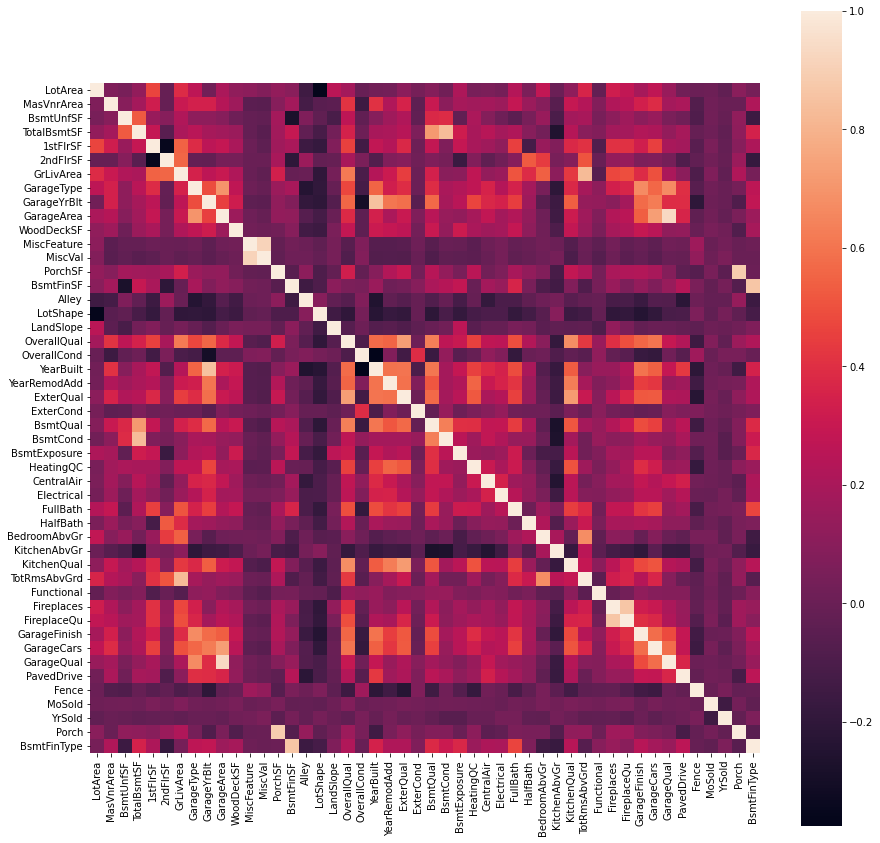

In [394]:
corrmat = data[Preprocess.numeric + Preprocess.ordinal].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrmat, square = True)
plt.show()

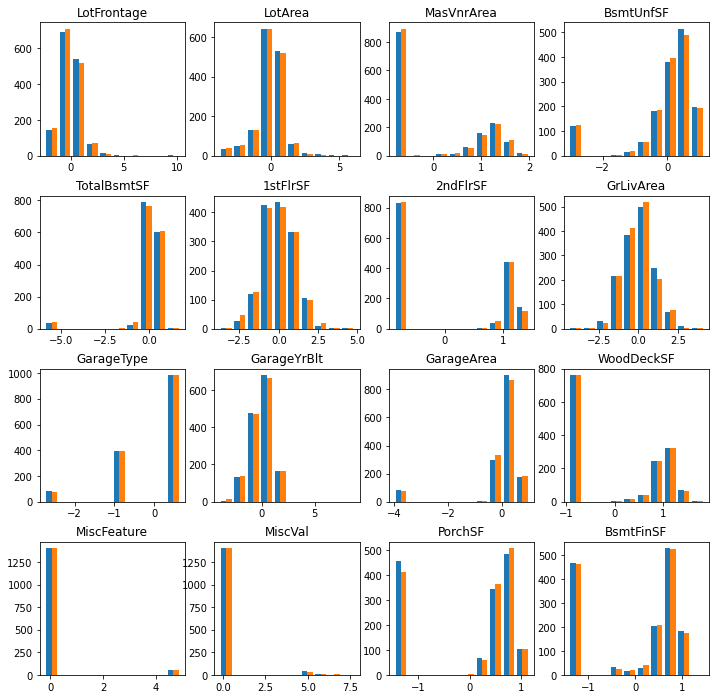

In [543]:
# Plot distributions of numeric variables
# Training data in blue, test data in orange
numeric = ['LotFrontage'] + Preprocess.numeric
r = 4
c = 4
fig, axs = plt.subplots(r, c, figsize=(12,12))
plt.subplots_adjust(hspace=0.3)
for i in range(len(numeric)):
    coln = numeric[i]
    axs[i//c,i%c].hist([data[coln],pred[coln]])
    axs[i//c,i%c].set_title(coln)
plt.show()

# Useful code

In [273]:
NA = data.isna().sum()
NA.sort_values(ascending=False, inplace=True)

In [274]:
NA.head(10)

MasVnrType     8
MasVnrArea     8
GarageType     6
MiscFeature    2
MSSubClass     0
Fireplaces     0
GarageYrBlt    0
FireplaceQu    0
Functional     0
GarageCars     0
dtype: int64

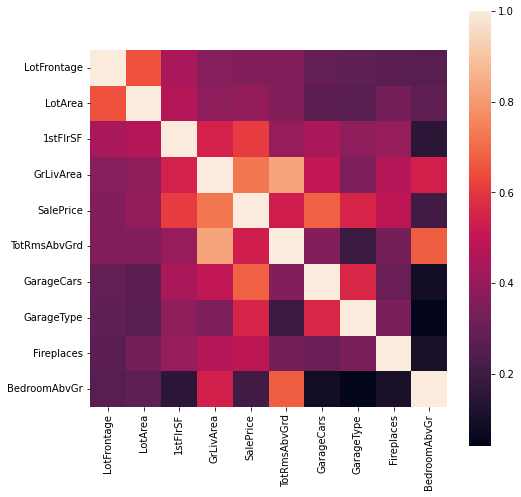

In [189]:
# The k features most correlated to a single feature
feat = 'LotFrontage'
k = 10
cols = corrmat.nlargest(k, feat)[feat].index

corrmat = data[cols].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corrmat, square = True)
plt.show()

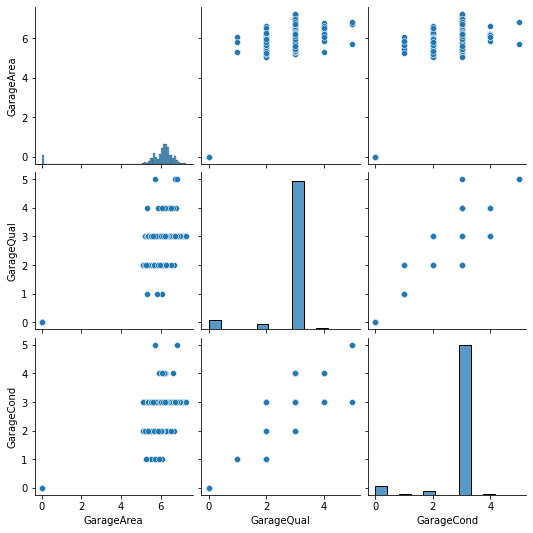

In [203]:
# Pairplot
sns.pairplot(data[['GarageArea','GarageQual','GarageCond']])
plt.show()

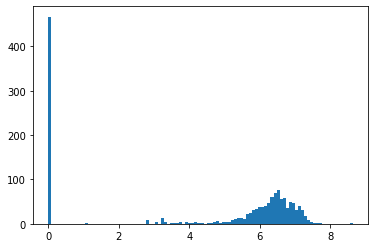

In [187]:
# Histogram
aux = data['BsmtFinSF']
plt.hist(aux,bins=100)
plt.show()

How did I do this for First Republic? Of generating the KDE separately.

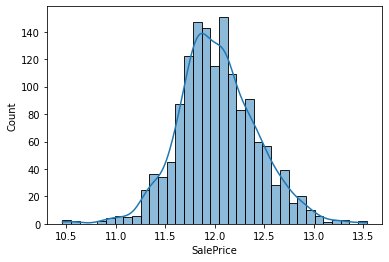

In [103]:
# Histogram with KDE
sns.histplot(data['SalePrice'], kde=True)
plt.show()

In [445]:
# Tally
Counter(list(data['YrSold']))

Counter({2008: 304, 2007: 329, 2006: 314, 2009: 338, 2010: 175})

In [450]:
key = next(key for key, val in a.items() if val == value)

In [451]:
key

2009

In [449]:
value = max(a.values())

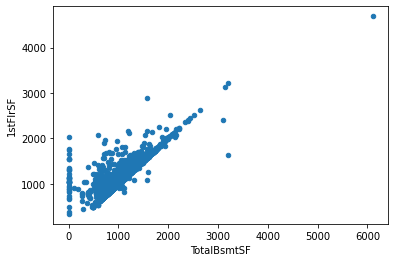

In [104]:
# Scatter
data.plot.scatter(x='TotalBsmtSF', y='1stFlrSF')
plt.show()

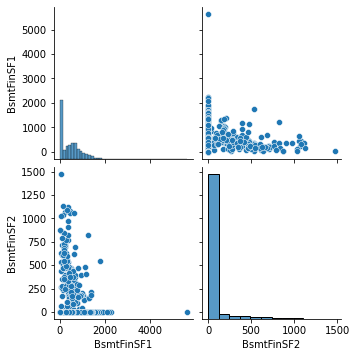

In [185]:
# Pairplot
sns.pairplot(data[['BsmtFinSF1','BsmtFinSF2']])
plt.show()

OverallCond and OverallQual might be too uncorrelated to the obj

<AxesSubplot:xlabel='LandContour', ylabel='LandSlope'>

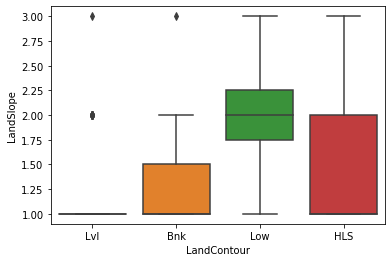

In [40]:
# Categorical/numeric
sns.boxplot(data=data,x='LandContour',y='LandSlope')

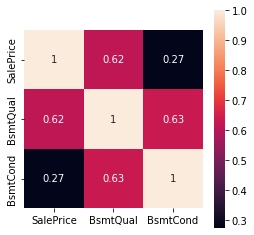

In [96]:
# Correlation matrix
plt.figure(figsize=(4,4))
sns.heatmap(data[['SalePrice','BsmtQual','BsmtCond']].corr(), square = True, annot=True)
plt.show()

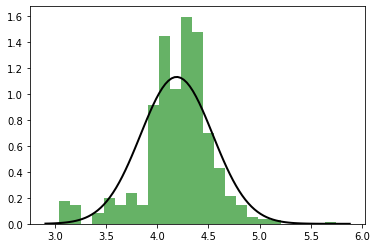

In [100]:
# Histogram with Gaussian fit
aux = data['LotFrontage']
vals = aux[~aux.isna()]

# Fit the Gaussian
mu, std = norm.fit(vals)

# Plot the histogram
plt.hist(vals, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

C:\Users\NICOLA~1\AppData\Local\Temp/ipykernel_6424/745848891.py:15: RuntimeWarning: invalid value encountered in true_divide
  counts[i,:] = counts[i,:] / np.sum(counts[i,:])


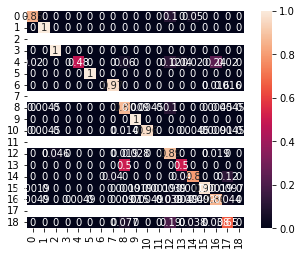

In [98]:
# Categorical correlations

# Checking Exterior1st and Exterior2nd correlations
s1 = data['Exterior1st']
s2 = data['Exterior2nd']
categories = np.unique(np.concatenate((np.unique(s1), np.unique(s2))))
n = len(categories)
counts = np.zeros(shape=(n,n))
for i in range(n):
    for j in range(n):
        counts[i,j] = sum((s1 == categories[i]) & (s2 == categories[j]))

# Normalize so each Exterior1st entry has values summing to 1
for i in range(n):
    counts[i,:] = counts[i,:] / np.sum(counts[i,:])
    
# Visualize
sns.heatmap(counts, square = True, annot=True)
plt.show()